In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


# Load data after feature engineering
train_df = pd.read_csv("data/processed/train_engineered.csv")
val_df = pd.read_csv("data/processed/validation_engineered.csv")

# Separate features & target
X_train, y_train = train_df.drop(columns=["Attrition"]), train_df["Attrition"]
X_val, y_val = val_df.drop(columns=["Attrition"]), val_df["Attrition"]

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to DataFrame to keep feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    

Calling ensemble implementation...
Starting ensemble model implementation...
Scaling data for Logistic Regression...

Training XGBoost model...
XGBoost AUC: 0.85761798851577

Training Random Forest model...
Random Forest AUC: 0.8224086641357712

Training Logistic Regression model...
Logistic Regression AUC: 0.8429711844607319

Combining predictions...

ROC Curve Analysis:
--------------------------------------------------

XGBoost:
AUC Score: 0.858
Performance Category: Good
Optimal Threshold: 0.482

Random Forest:
AUC Score: 0.822
Performance Category: Good
Optimal Threshold: 0.477

Logistic Regression:
AUC Score: 0.843
Performance Category: Good
Optimal Threshold: 0.474

Ensemble:
AUC Score: 0.852
Performance Category: Good
Optimal Threshold: 0.473

Best Performing Model: XGBoost (AUC = 0.858)


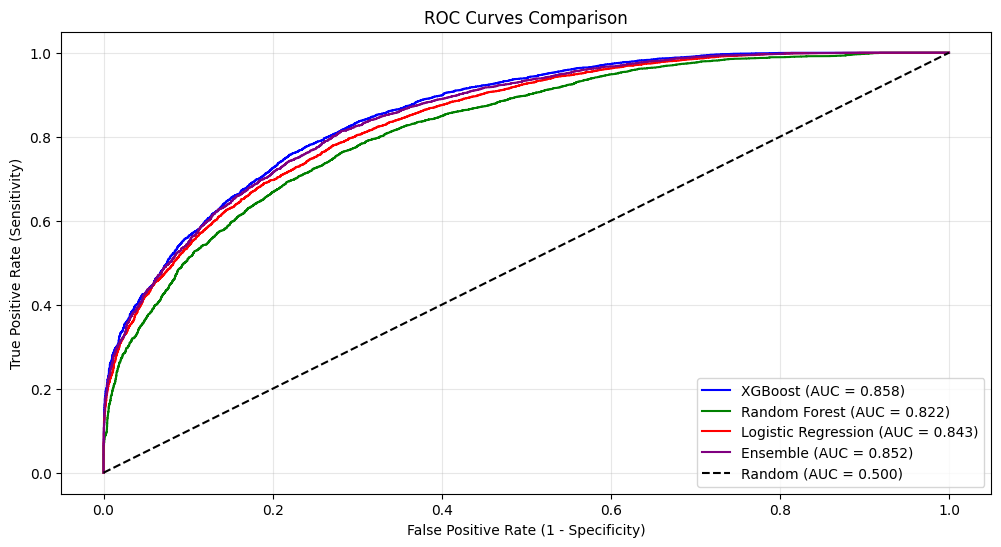


Final Ensemble Model Performance:
------------------------------
ACCURACY    : 0.7612
PRECISION   : 0.7524
RECALL      : 0.7452
F1          : 0.7488
ROC_AUC     : 0.8519


In [2]:
def implement_simple_ensemble(X_train, y_train, X_val, y_val):
    """
    Implement ensemble model with scaling only for Logistic Regression
    and ROC curve analysis
    """
    print("Starting ensemble model implementation...")
    
    # Scale data only for Logistic Regression
    print("Scaling data for Logistic Regression...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Convert to DataFrame to keep feature names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    
    # Create and train XGBoost
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
    print("XGBoost AUC:", roc_auc_score(y_val, xgb_pred_proba))
    
    # Create and train Random Forest
    print("\nTraining Random Forest model...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        min_samples_split=5,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    rf_pred_proba = rf_model.predict_proba(X_val)[:, 1]
    print("Random Forest AUC:", roc_auc_score(y_val, rf_pred_proba))
    
    # Create and train Logistic Regression
    print("\nTraining Logistic Regression model...")
    lr_model = LogisticRegression(
        max_iter=2000,
        solver='lbfgs',
        C=1.0,
        class_weight='balanced',
        random_state=42
    )
    lr_model.fit(X_train_scaled, y_train)
    lr_pred_proba = lr_model.predict_proba(X_val_scaled)[:, 1]
    print("Logistic Regression AUC:", roc_auc_score(y_val, lr_pred_proba))
    
    # Combine predictions with weights
    print("\nCombining predictions...")
    weights = [2, 2, 1]  # weights for XGB, RF, and LR respectively
    weighted_probs = (weights[0] * xgb_pred_proba + 
                     weights[1] * rf_pred_proba + 
                     weights[2] * lr_pred_proba) / sum(weights)
    
    # Analyze ROC curves
    def analyze_roc_curves(y_true, probas_dict):
        plt.figure(figsize=(12, 6))
        results = {}
        
        colors = ['blue', 'green', 'red', 'purple']
        for (name, proba), color in zip(probas_dict.items(), colors):
            fpr, tpr, thresholds = roc_curve(y_true, proba)
            auc = roc_auc_score(y_true, proba)
            
            results[name] = {
                'auc': auc,
                'performance': 'Excellent' if auc > 0.9 else
                             'Good' if auc > 0.8 else
                             'Fair' if auc > 0.7 else
                             'Poor' if auc > 0.6 else 'Failed'
            }
            
            plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {auc:.3f})')
            
            # Find optimal threshold
            optimal_idx = np.argmin(np.sqrt((1-tpr)**2 + fpr**2))
            optimal_threshold = thresholds[optimal_idx]
            results[name]['optimal_threshold'] = optimal_threshold
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Print interpretation
        print("\nROC Curve Analysis:")
        print("-" * 50)
        for model, metrics in results.items():
            print(f"\n{model}:")
            print(f"AUC Score: {metrics['auc']:.3f}")
            print(f"Performance Category: {metrics['performance']}")
            print(f"Optimal Threshold: {metrics['optimal_threshold']:.3f}")
        
        best_model = max(results.items(), key=lambda x: x[1]['auc'])
        print(f"\nBest Performing Model: {best_model[0]} (AUC = {best_model[1]['auc']:.3f})")
        
        plt.show()
        return results
    
    # Analyze ROC curves
    probas_dict = {
        'XGBoost': xgb_pred_proba,
        'Random Forest': rf_pred_proba,
        'Logistic Regression': lr_pred_proba,
        'Ensemble': weighted_probs
    }
    
    roc_results = analyze_roc_curves(y_val, probas_dict)
    
    # Convert probabilities to predictions using optimal threshold
    y_pred = (weighted_probs >= 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, weighted_probs)
    }
    
    # Print final metrics
    print("\nFinal Ensemble Model Performance:")
    print("-" * 30)
    for metric, value in metrics.items():
        print(f"{metric.upper():12}: {value:.4f}")
    
    return {
        'models': {
            'xgb': xgb_model,
            'rf': rf_model,
            'lr': lr_model
        },
        'scaler': scaler,
        'metrics': metrics,
        'predictions': y_pred,
        'probabilities': weighted_probs,
        'roc_analysis': roc_results
    }

# Call the function
print("Calling ensemble implementation...")
ensemble_results = implement_simple_ensemble(X_train, y_train, X_val, y_val)